<a href="https://colab.research.google.com/github/gauravsharma2/A6---defect-prediction/blob/main/Mushroom_images_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
ZIP_PATH       = '/content/Mushrooms.zip'
import os
import zipfile
EXTRACT_DIR    = '/content'
ZIP_PATH       = '/content/Mushrooms.zip'
DATA_DIR       = '/content/Mushrooms'
if os.path.exists(ZIP_PATH):
  print(f"Unzipping {ZIP_PATH} to {EXTRACT_DIR}...")
  with zipfile.ZipFile(ZIP_PATH, 'r') as z:
            z.extractall(EXTRACT_DIR)
  print(f"Extraction complete. DATA_DIR = {DATA_DIR}")
else:
  print(f"Zip not found at {ZIP_PATH}")

print('Data source import complete.')


Unzipping /content/Mushrooms.zip to /content...
Extraction complete. DATA_DIR = /content/Mushrooms
Data source import complete.


# Neural network classifier for mushrooms

In [21]:
import os
import shutil
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.python.framework.config import list_physical_devices, set_memory_growth

In [22]:
# To fix "Image File is truncated" error during training
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [24]:
# Settings for displaying charts
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 12})

In [25]:
physical_devices = list_physical_devices('GPU')
print(f'Number of GPUs available: {len(physical_devices)}')

if len(physical_devices) > 0:
    set_memory_growth(physical_devices[0], True)

Number of GPUs available: 1


In [26]:
# TensorFlow settings
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 299
BATCH_SIZE = 64

## Loading and processing data

In [37]:
# Path to the folder with 9 classes of images:
data_path = '/content/Mushrooms/'

In [28]:
# Temporary folders for training, validation and test images:
os.mkdir('/content/temp')
os.chdir('/content/temp')
os.mkdir('train')
os.mkdir('valid')
os.mkdir('test')
os.chdir('/content/working')

FileExistsError: [Errno 17] File exists: '/content/temp'

In [39]:
import os
import shutil

data_path = '/content/Mushrooms'  # adjust if your path is different

base_temp = '/content/temp'
train_base = os.path.join(base_temp, 'train')
valid_base = os.path.join(base_temp, 'valid')
test_base  = os.path.join(base_temp, 'test')

# create top‐level split dirs
for p in (train_base, valid_base, test_base):
    os.makedirs(p, exist_ok=True)

for subfolder in os.listdir(data_path):
    original_path = os.path.join(data_path, subfolder)
    # skip anything that isn't a folder
    if not os.path.isdir(original_path):
        continue

    files = [f for f in os.listdir(original_path)
             if os.path.isfile(os.path.join(original_path, f))]
    n = len(files)
    train_end = int(n * 0.75)
    valid_end = int(n * 0.90)

    # make class folders
    train_path = os.path.join(train_base, subfolder)
    valid_path = os.path.join(valid_base, subfolder)
    test_path  = os.path.join(test_base,  subfolder)
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(valid_path, exist_ok=True)
    os.makedirs(test_path,  exist_ok=True)

    # copy into splits
    for idx, fname in enumerate(files):
        src = os.path.join(original_path, fname)
        if idx < train_end:
            dst = os.path.join(train_path, fname)
        elif idx < valid_end:
            dst = os.path.join(valid_path, fname)
        else:
            dst = os.path.join(test_path, fname)
        shutil.copyfile(src, dst)


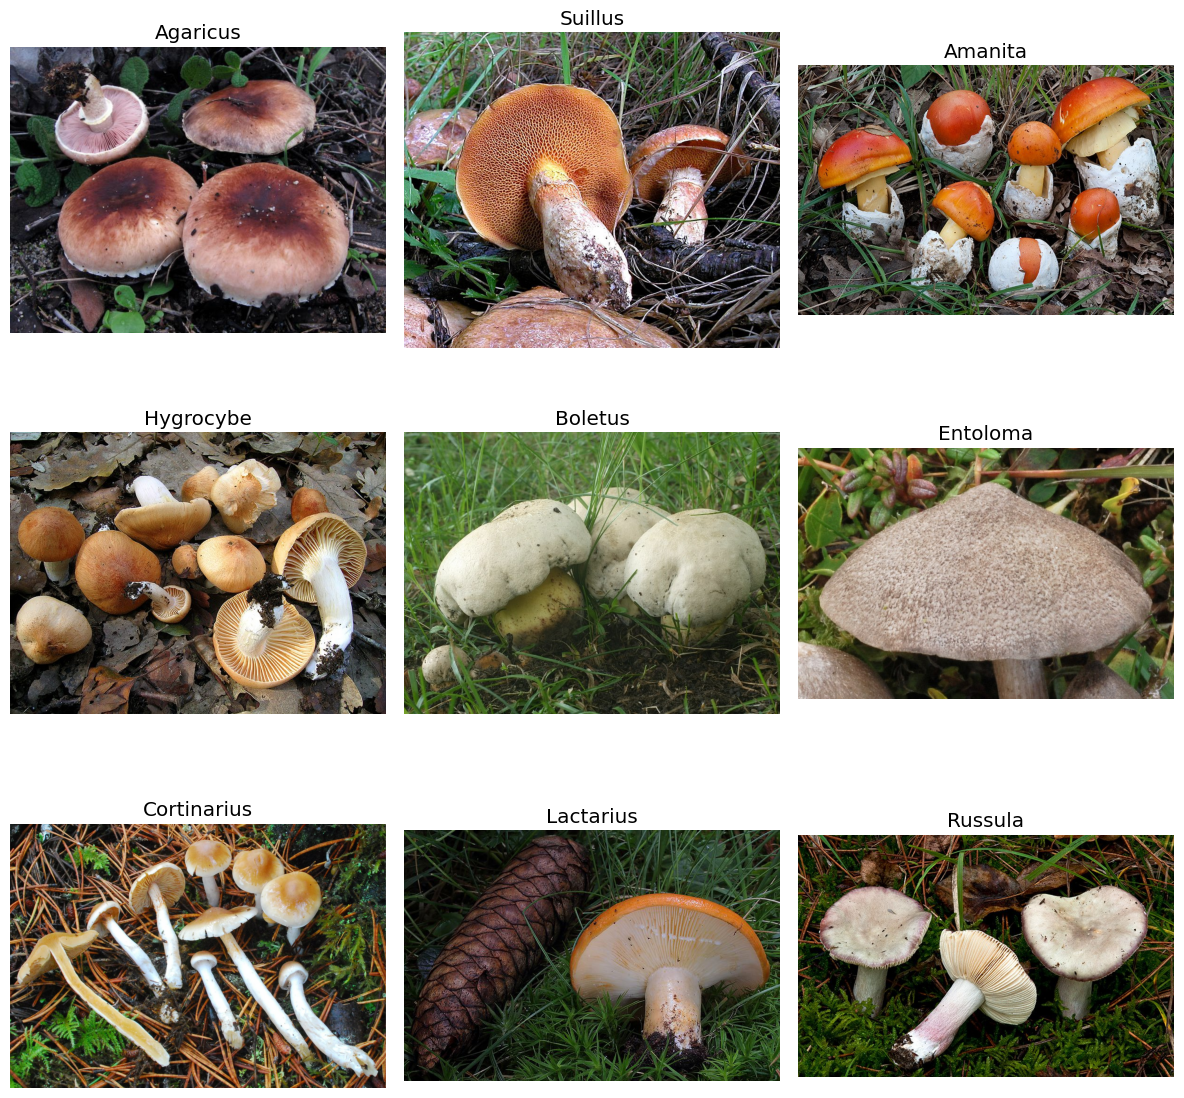

In [41]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# only keep real subfolders
class_dirs = [
    d for d in os.listdir(data_path)
    if os.path.isdir(os.path.join(data_path, d))
]

nrows, ncols = 3, 3
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for pos, subfolder in enumerate(class_dirs, start=1):
    # list only files in the subfolder
    folder_path = os.path.join(data_path, subfolder)
    files = [
        f for f in os.listdir(folder_path)
        if os.path.isfile(os.path.join(folder_path, f))
    ]
    if not files:
        continue  # empty class folder?

    image_file = files[0]
    sp = plt.subplot(nrows, ncols, pos)
    img = mpimg.imread(os.path.join(folder_path, image_file))
    plt.imshow(img)
    plt.title(subfolder)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [42]:
# Create image datasets
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='/content/temp/train',
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
valid_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='/content/temp/valid',
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='/content/temp/test',
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

Found 5033 images belonging to 9 classes.
Found 1005 images belonging to 9 classes.
Found 676 images belonging to 9 classes.


## Creating a model

In [43]:
# Pretrained EfficientNetB7 image classification model without final layers
feature_model = tf.keras.applications.EfficientNetB7(weights='imagenet',
                                                     include_top=False,
                                                     input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                     pooling='avg')

feature_model.summary()

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "efficientnetb7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 299, 299,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 299, 299,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 299, 299,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │      2,048 │ block1a_se_excit

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 63,786,960 (243.33 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [44]:
# Construct a new model with the final dense layer for 9 classes
new_model = tf.keras.models.Sequential(
    [
        feature_model,
        tf.keras.layers.Dense(9, activation='softmax')
    ]
)

In [45]:
# Make all the layers from the original ResNet model untrainable
new_model.layers[0].trainable = False

In [46]:
# Metrics and optimizer
new_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [47]:
# Check the architecture of the new model
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 2560)           │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │        23,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,120,736 (244.60 MB)

 Trainable params: 23,049 (90.04 KB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [48]:
# Callbacks to be exercised during training
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=10,
                                              restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.1,
                                                 mode='max',
                                                 cooldown=2,
                                                 patience=2,
                                                 min_lr=0)

In [50]:
history = new_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    steps_per_epoch=79,
    validation_steps=16,
    verbose=2,
    callbacks=[reduce_lr, early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
79/79 - 250s - 3s/step - accuracy: 0.5090 - loss: 1.4264 - val_accuracy: 0.6129 - val_loss: 1.0994 - learning_rate: 1.0000e-03
Epoch 2/20
79/79 - 82s - 1s/step - accuracy: 0.6672 - loss: 1.0214 - val_accuracy: 0.7144 - val_loss: 0.9149 - learning_rate: 1.0000e-03
Epoch 3/20
79/79 - 142s - 2s/step - accuracy: 0.7280 - loss: 0.8822 - val_accuracy: 0.7284 - val_loss: 0.8286 - learning_rate: 1.0000e-03
Epoch 4/20
79/79 - 87s - 1s/step - accuracy: 0.7497 - loss: 0.7974 - val_accuracy: 0.7552 - val_loss: 0.7763 - learning_rate: 1.0000e-03
Epoch 5/20
79/79 - 139s - 2s/step - accuracy: 0.7701 - loss: 0.7401 - val_accuracy: 0.7721 - val_loss: 0.7276 - learning_rate: 1.0000e-03
Epoch 6/20
79/79 - 87s - 1s/step - accuracy: 0.7799 - loss: 0.6954 - val_accuracy: 0.7701 - val_loss: 0.7091 - learning_rate: 1.0000e-03
Epoch 7/20
79/79 - 87s - 1s/step - accuracy: 0.7952 - loss: 0.6593 - val_accuracy: 0.7851 - val_loss: 0.6689 - learning_rate: 1.0000e-03
Epoch 8/20
79/79 - 88s - 1s/step - acc

In [51]:
# ▶️ Save as a single HDF5 file
model_path = '/content/mushroom_classifier.h5'
new_model.save(model_path)
print(f'Model saved to: {model_path}')

# ▶️ Save only the weights (HDF5 format)
weights_path = '/content/mushroom_weights.h5'
new_model.save_weights(weights_path, save_format='h5')
print(f'Weights saved to: {weights_path}')


Model saved to: /content/mushroom_classifier.h5


# Displaying the results

In [53]:
# 1) wrap your generator
test_ds = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 9), dtype=tf.float32),
    )
)

# 2) add prefetch for overlap of preprocessing & model execution
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

# 3) evaluate on the dataset
loss, accuracy = new_model.evaluate(
    test_ds,
    steps=11,
    verbose=2
)
print(f'Model performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')


11/11 - 32s - 3s/step - accuracy: 0.8151 - loss: 0.5880
Model performance on test images:
Accuracy = 0.8150887489318848
Loss = 0.5880265831947327


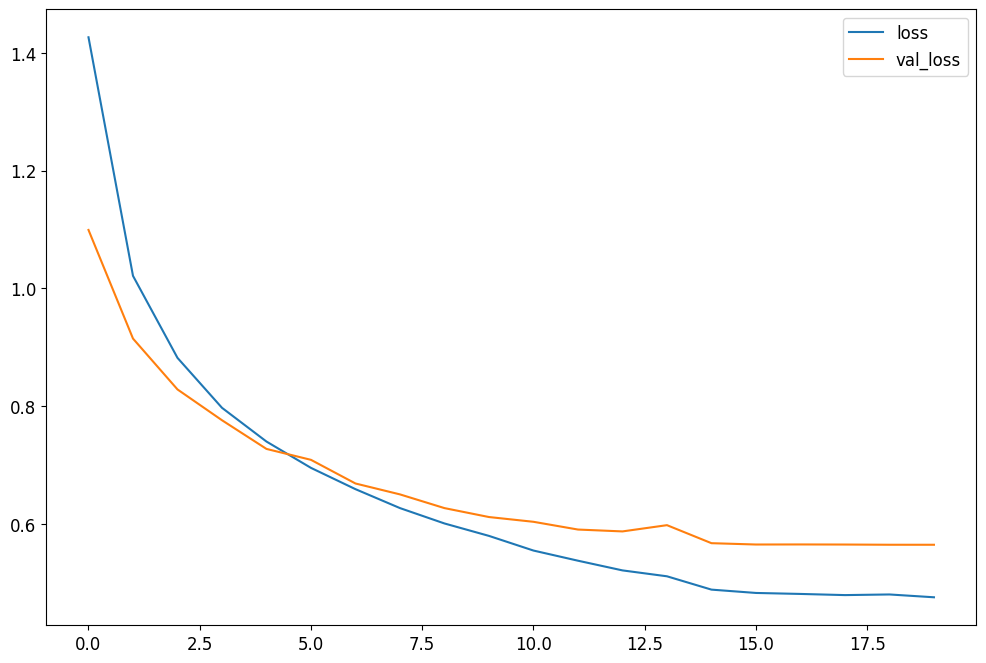

In [54]:
# Loss during training:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot();

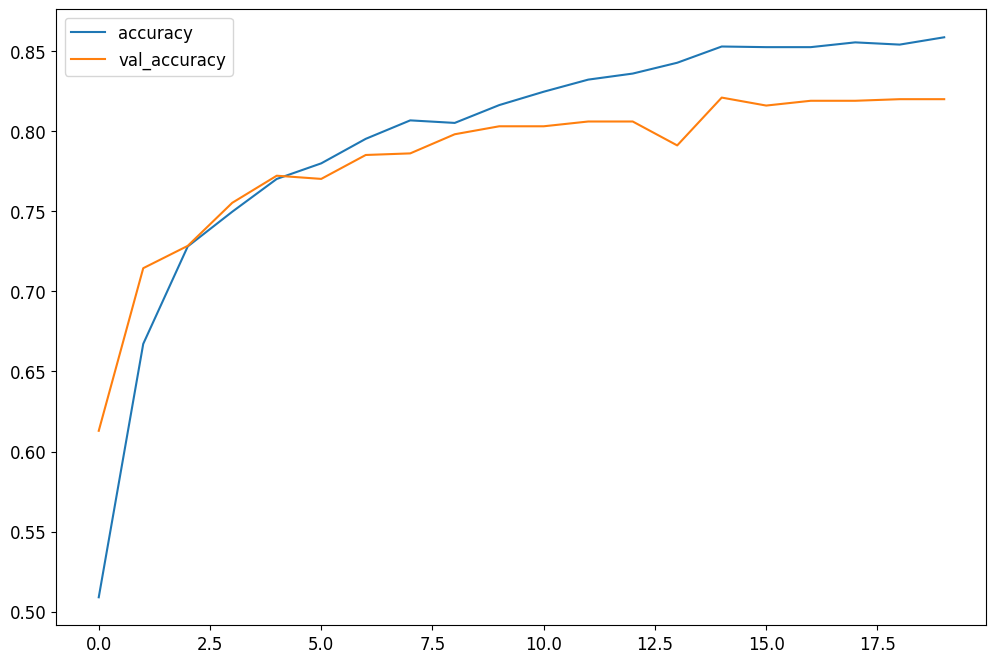

In [55]:
# Accuracy during training:
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [58]:
# ▶️ Save only the weights (HDF5 format)
weights_path = '/content/mushroom_weights.weights.h5'
new_model.save_weights(weights_path)
print(f'Weights saved to: {weights_path}')


Weights saved to: /content/mushroom_weights.weights.h5


In [56]:
!pip install h5py


1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step


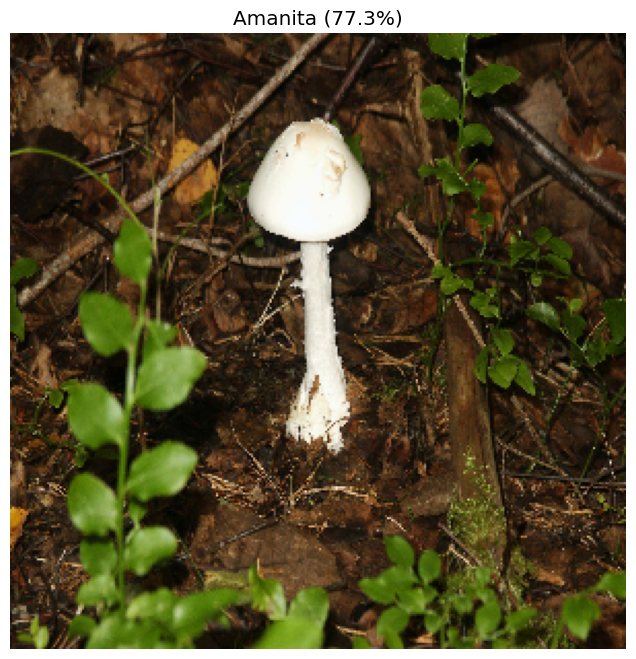

test1.jpg → Amanita (77.3%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


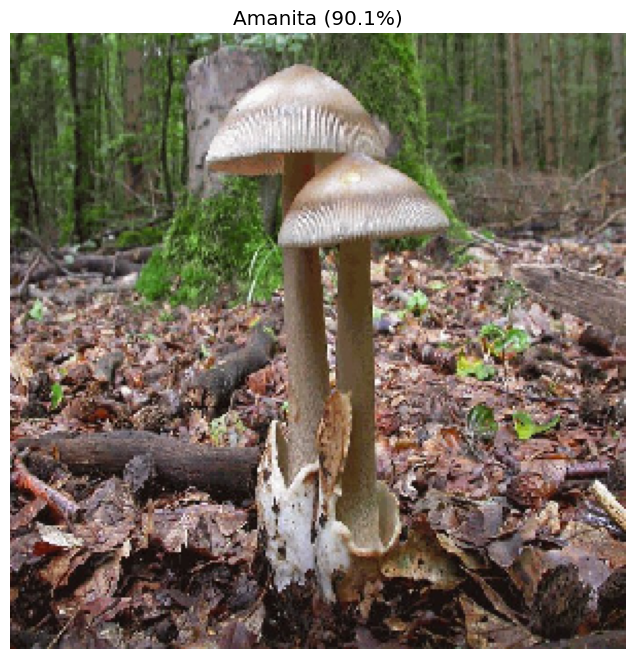

test2.jpg → Amanita (90.1%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


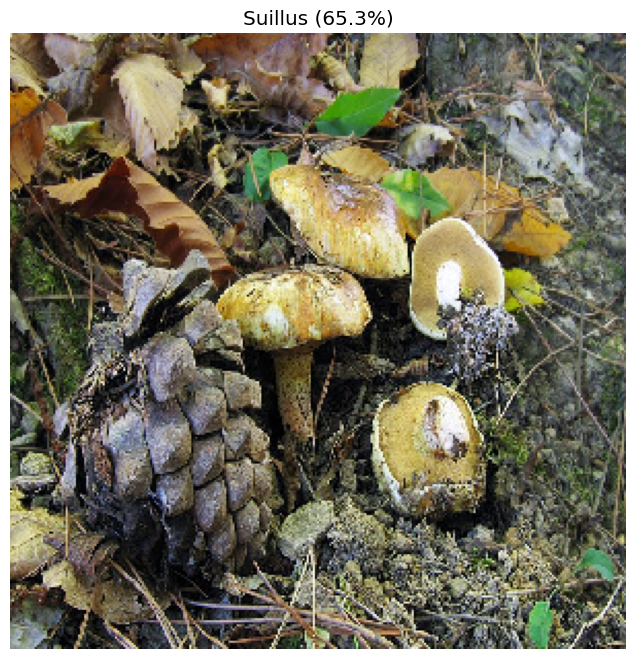

test3.jpg → Suillus (65.3%)


In [60]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import os

# Pull the expected spatial dims straight from the model:
_, IMG_H, IMG_W, _ = new_model.input_shape

# Invert your class mapping:
inv_class_map = {v:k for k,v in train_generator.class_indices.items()}

# Your three test files:
test_image_paths = [
    '/content/test1.jpg',
    '/content/test2.jpg',
    '/content/test3.jpg',
]

for img_path in test_image_paths:
    # load & resize to (IMG_H, IMG_W)
    img = image.load_img(img_path, target_size=(IMG_H, IMG_W))
    x   = image.img_to_array(img)[None, ...]        # shape (1,H,W,3)
    x   = preprocess_input(x)                       # match training preprocess

    preds     = new_model.predict(x)
    idx       = np.argmax(preds[0])
    label     = inv_class_map[idx]
    conf      = preds[0][idx]

    plt.imshow(img)
    plt.title(f'{label} ({conf:.1%})')
    plt.axis('off')
    plt.show()

    print(f'{os.path.basename(img_path)} → {label} ({conf:.1%})')
